## 5-1. Variational Quantum Eigensolver（VQE）アルゴリズム

まず、物質科学と量子化学への応用が期待されているアルゴリズム、VQE (Variational Quantum Eigensolver : 変分量子固有値ソルバー) アルゴリズムを紹介する。このアルゴリズムは物質の基底エネルギーの値を求めるのに用いられる。

### 背景

分子や物質の性質は、ほとんどの場合その中に存在する電子の動きによって決まっていると考えられている。したがって、電子を支配する方程式であるシュレディンガー方程式([4-1節](4.1_quantum_simulation.ipynb)も参照)

$$ H|\psi\rangle = E|\psi\rangle$$

を解けば、分子や物質の性質を計算によって明らかにすることができる。ここで $H$ はハミルトニアンと呼ばれる演算子 (行列) であり、分子の形など、系の詳細によって決まる。$ H |\psi\rangle = E|\psi\rangle$ の形からもわかるように、シュレディンガー方程式を解くということは、ハミルトニアン $H$ の固有値問題を解き、固有値 $E_i$ と対応する固有ベクトル (固有状態とも呼ばれる) $|\phi_i\rangle$ を求めることと同値である。このとき固有値 $E_i$ は、固有状態 $|\phi_i\rangle$ の持つエネルギーとなる。

この問題を解くことを、化学分野では**量子化学計算**と呼び、現在も問題の解法について活発な研究が進められている。というのも、この問題は電子の数に対して指数的に難しくなるため、分子のサイズや結晶の単位格子が大きくなれば、厳密に解くことは実質不可能になる。そこで様々な近似解法が研究されているのだ。この問題の難しさは、$H$ が量子状態に作用する行列であって、粒子数が多くなればその次元が指数的に大きくなっていくところを原因としている。

### 変分法
極限的な環境を考えない限り、電子の状態は通常一番エネルギーの低い状態、すなわち基底状態に落ちていることがほとんどである。そこで固有状態の中でも、特に基底状態が興味を持たれる。

非常に大きな次元を持つハミルトニアンの基底状態を求めるのに有力な手法として、**変分法**がある。変分法では、任意の状態 $|\psi\rangle$ についてそのエネルギー期待値が必ず基底エネルギー $E_0$ よりも高くなる、つまり

$$\langle \psi|H|\psi\rangle \geq E_0$$

となることを使う。(このことは[変分原理](https://ja.wikipedia.org/wiki/変分原理#リッツの変分原理)とも呼ばれる。) このことから、ランダムに状態 $\{|\psi_i\rangle\}$ をたくさん持ってきて、その中で一番エネルギーが低い状態を見つければ、それは $\{|\psi_i\rangle\}$ の中で最も基底状態に近い状態であると考えられるだろう。

実際には、ランダムに状態を持ってきていたのでは、基底状態に近い状態が得られる確率は系のサイズに対して指数的に小さくなってしまう。そこで普通は物理的・化学的直観や経験をもとにパラメータ付きの量子状態 $|\psi(\theta)\rangle$ ($\theta$ はパラメータ) を構成し、

$$\langle \psi(\theta)|H|\psi(\theta)\rangle$$

を最小化するような $\theta$ を見つけるというアプローチがとられる。古典コンピュータ上で計算をする都合上、これまでは量子状態 $|\psi(\theta)\rangle$ は、古典計算機でも効率的に記述できるものの中から選ぶ必要があった。


### VQEとは

VQE とは、**変分法に対して、量子コンピュータで効率的に記述できる量子状態を用いて基底状態を探索するアルゴリズムである。**

アルゴリズムは以下のようになる。

1. 量子コンピュータ上で量子状態$|\psi(\theta)\rangle$を生成する。

2. $\langle H(\theta)\rangle = \langle \psi(\theta)|H|\psi(\theta)\rangle$ を測定する。  

3. 測定結果をもとに、古典コンピュータによって $\langle\psi(\theta)|H|\psi(\theta)\rangle$ が小さくなるような $\theta$ を決定する。

これを $\langle\psi(\theta)|H|\psi(\theta)\rangle$ が収束するまで繰り返すことで、近似的な基底状態を求める。  

![VQE-concept](figs/5/VQE_concept.png)

(図の引用：参考文献[1])


### 実装例

以下ではnumpyを使ったVQEの実装例を示す。（もちろん、Qulacsでも簡単に実装できるので、余裕のある読者はチャレンジしてみてほしい）   
ここではH-He$^+$(水素化ヘリウムイオン)の基底エネルギーを求める。使用する量子ビットは2個で、参考文献[1]に従って実装していく。

### 量子ゲートの準備

In [2]:
import numpy as np
nqubits = 2
#パウリ演算子を準備する。
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

In [3]:
#パウリ演算子を1量子ゲートに変換する。
X=[1]*(nqubits)
Y=[1]*(nqubits)
Z=[1]*(nqubits)
H=[1]*(nqubits)
P0=[1]*(nqubits)
P1=[1]*(nqubits)

for i in range(nqubits):
    for j in range(nqubits):
        if(i != j):
            X[i] = np.kron(pI,X[i])
            Y[i] = np.kron(pI,Y[i])
            Z[i] = np.kron(pI,Z[i])
            H[i] = np.kron(pI,H[i])
            P0[i] = np.kron(pI,P0[i])
            P1[i] = np.kron(pI,P1[i])
        else:
            X[i] = np.kron(pX,X[i])
            Y[i] = np.kron(pY,Y[i])
            Z[i] = np.kron(pZ,Z[i])
            H[i] = np.kron(pHad,H[i])
            P0[i] = np.kron(pP0,P0[i])
            P1[i] = np.kron(pP1,P1[i])
Ide = np.eye(2**nqubits)

In [4]:
#2量子ゲートを準備する。
CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

for i in range(nqubits):
    for j in range(nqubits):
        CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
        CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

In [5]:
#変分量子ゲート(X,Y,Zに関する回転の角度を指定できるゲート)を準備する。
from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

In [6]:
#初期状態|0000・・・0>を準備する。
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

### ハミルトニアンを準備する

参考文献[1]の [Supplementary Information](https://media.nature.com/original/nature-assets/ncomms/2014/140723/ncomms5213/extref/ncomms5213-s1.pdf) の表から、H-He間の距離が$0.9$オングストロームの時のハミルトニアンの係数を読み取り、定義する。このハミルトニアンの最小エネルギー固有状態を求めれば、様々なH-He$^+$分子の性質を知ることができる。

※ このハミルトニアンは、電子-原子核間のクーロン相互作用および電子同士のクーロン相互作用の大きさから導かれている。詳細は第6章の量子化学計算に関する項で学ぶことになる。

In [8]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + \
     0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2

### 量子回路を準備する

論文と全く同じ形式の変分量子回路を以下のように実装する。

In [14]:
n_param = 6
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

### 量子状態のエネルギー期待値を測定する

変分量子回路によって出力される状態のエネルギー期待値を算出する関数を以下のように定義する。

In [15]:
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
    tmp = np.dot(BraState,np.dot(Operator,State)) #行列を列ベクトルと行ベクトルではさむ
    return np.real(tmp) #要素の実部を取り出す

### エネルギー期待値の最小化
エネルギー期待値の最小化を、`scipy.optimize.minimize` に実装されている Powell 法によって行う。Powell 法は勾配情報を使わない最適化手法の一つである。パラメータの初期値はランダムに指定する。

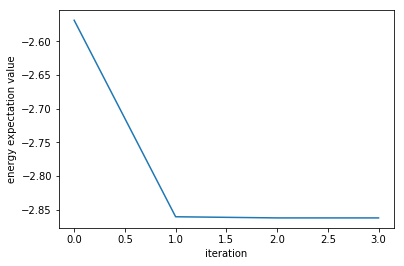

In [32]:
import scipy.optimize
import matplotlib.pyplot as plt

def cost(phi):
    return ExpectVal(M, TwoQubitPQC(phi))

cost_val = [] #コスト関数の変化を保存するための関数

#この関数がiteration ごとに呼ばれる。
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

init = np.random.rand(n_param)
callback(init)
res = scipy.optimize.minimize(cost, init, 
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

ハミルトニアンを対角化して得られた厳密なエネルギーと比べることで、VQE によって算出された値が正しいか検証してみよう。

In [23]:
import scipy.linalg
l, P = scipy.linalg.eigh(M)
print(l[0]) #最小固有値
print(cost(res.x)) #VQEの結果

-2.8626207640766816
-2.8623984117519257


Powell法で算出した固有値と一致はしていないものの、小数第3位まで同じであるので、殆ど正しいと言っていいだろう。　

次に回路の出力にノイズが存在するケースでも検証してみよう。NISQでは出力にエラー（ノイズ）がのることが避けられないため、ノイズありでもアルゴリズムが動くのか・どの程度のノイズまでなら耐えられるのかといった検証は非常に重要である。

In [24]:
def cost(phi):
    return ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)

def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

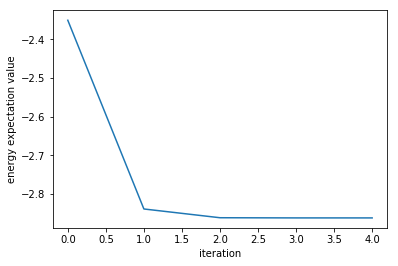

-2.862398401331204


In [34]:
cost_val=[] # コスト関数の履歴
init = np.random.rand(6)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()
print(cost(res.x))

ノイズが小さければほとんど同じような振る舞いで最適化が行えることがわかる。（興味のある読者はぜひノイズを大きくして実験してみてほしい。）

### 参考文献 
[1] A. Peruzzo _et al_. , "A variational eigenvalue solver on a photonic quantum processor" [Nat. Commun. 5:4213 doi: 10.1038/ncomms5213 (2014)](https://www.nature.com/articles/ncomms5213) 